# Initialisation:
For each node 𝑖:
Load: 𝐿𝑖 = betweenness centrality of node 𝑖

Capacity: 𝐶𝑖 = (1+𝛼)*𝐿𝑖

where 𝛼 > 0 is a tolerance parameter.

A node fails if: 𝐿𝑖 > 𝐶𝑖

# First Attack:
Remove one node (e.g. Node 8, or highest-betweenness node)

# Cascade Dynamics:
Repeat until no new failures occur.

- Recompute betweenness on the remaining graph
- Update loads 𝐿𝑖
- Remove all nodes with 𝐿𝑖 > 𝐶𝑖

# Measure Damage:
Track:
- number of failed nodes
- size of largest connected component
- number of cascade steps

In [12]:
import networkx as nx
import numpy as np
import random

from cascade_failure.updated_model import load_data

G0 = load_data()
G0 = G0.copy()


# --------------------------------------------------
# Betweenness-based load and capacity initialization
# --------------------------------------------------
def initialize_betweenness_loads(G, alpha=0.2):
    bet = nx.betweenness_centrality(G, normalized=True)
    for n in G.nodes():
        G.nodes[n]["load"] = bet[n]
        G.nodes[n]["capacity"] = (1 + alpha) * bet[n]
        G.nodes[n]["failed"] = False

# def initialize_betweenness_loads(G):
#     bet=nx.betweenness_centrality(G, normalized=True)
#     for n in G.nodes():
#         capacity=bet[n]*random.uniform(10, 50)
#         load= capacity*random.uniform(0.1, 0.3)

#         G.nodes[n]['capacity']=capacity
#         G.nodes[n]['load']=load
#         G.nodes[n]['failed']=False

# --------------------------------------------------
# Cascading failure simulation
# --------------------------------------------------
def cascade_failure(G, initial_attack=None, verbose=False):
    G = G.copy()
    initialize_betweenness_loads(G)

    failed_nodes = set()
    step = 0

    lcc_history= []

    # Initial attack
    if initial_attack is not None:
        G.remove_node(initial_attack)
        failed_nodes.add(initial_attack)

    if G.number_of_nodes() > 0:
        lcc_history.append(len(max(nx.connected_components(G), key=len)))
    else:
        lcc_history.append(0)

    while True:
        step += 1
        bet = nx.betweenness_centrality(G, normalized=True)

        newly_failed = []
        for n in G.nodes():
            load = bet[n]
            capacity = G.nodes[n]["capacity"]
            if load > capacity:
                newly_failed.append(n)

        if not newly_failed:
            break

        if verbose:
            print(f"Step {step}: {len(newly_failed)} new failures")

        for n in newly_failed:
            G.remove_node(n)
            failed_nodes.add(n)

        if G.number_of_nodes() > 0:
            lcc_history.append(len(max(nx.connected_components(G), key=len)))
        else:
            lcc_history.append(0)

    # Metrics
    if G.number_of_nodes() > 0:
        largest_cc = len(max(nx.connected_components(G), key=len))
    else:
        largest_cc = 0

    return {
    "failed_nodes": failed_nodes,
    "num_failed": len(failed_nodes),
    "largest_cc": largest_cc,
    "remaining_nodes": G.number_of_nodes(),
    "steps": step,
    "lcc_history": lcc_history,
    "final_graph": G}


Graph loaded: 4941 nodes, 6594 edges


In [3]:
import networkx as nx
from cascade_failure.updated_model import load_data

G0 = load_data()
G0 = G0.copy()

def initialize_degree_loads(G, alpha=0.2):
    deg=nx.degree_centrality(G)    
    for n in G.nodes():
        G.nodes[n]["load"] = deg[n]
        G.nodes[n]["capacity"] = (1 + alpha) * deg[n]
        G.nodes[n]["failed"] = False

def cascade_failure(G, initial_attack=None, verbose=False):
    G = G.copy()
    initialize_degree_loads(G)

    failed_nodes = set()
    step = 0

    lcc_history= []

    # Initial attack
    if initial_attack is not None:
        G.remove_node(initial_attack)
        failed_nodes.add(initial_attack)

    if G.number_of_nodes() > 0:
        lcc_history.append(len(max(nx.connected_components(G), key=len)))
    else:
        lcc_history.append(0)

    while True:
        step += 1
        deg = nx.degree_centrality(G)

        newly_failed = []
        for n in G.nodes():
            load = deg[n]
            capacity = G.nodes[n]["capacity"]
            if load > capacity:
                newly_failed.append(n)

        if not newly_failed:
            break

        if verbose:
            print(f"Step {step}: {len(newly_failed)} new failures")

        for n in newly_failed:
            G.remove_node(n)
            failed_nodes.add(n)

        if G.number_of_nodes() > 0:
            lcc_history.append(len(max(nx.connected_components(G), key=len)))
        else:
            lcc_history.append(0)

    # Metrics
    if G.number_of_nodes() > 0:
        largest_cc = len(max(nx.connected_components(G), key=len))
    else:
        largest_cc = 0

    return {
    "failed_nodes": failed_nodes,
    "num_failed": len(failed_nodes),
    "largest_cc": largest_cc,
    "remaining_nodes": G.number_of_nodes(),
    "steps": step,
    "lcc_history": lcc_history,
    "final_graph": G}

Graph loaded: 4941 nodes, 6594 edges


In [4]:
result_node8 = cascade_failure(
    G0,
    initial_attack=8,
    verbose=True
)

print(result_node8)

{'failed_nodes': {8}, 'num_failed': 1, 'largest_cc': 4938, 'remaining_nodes': 4940, 'steps': 1, 'lcc_history': [4938], 'final_graph': <networkx.classes.graph.Graph object at 0x10c580050>}


In [5]:
# Degree centrality node
deg = nx.degree_centrality(G0)
top_node = max(deg, key=deg.get)

result_top = cascade_failure(G0, initial_attack=top_node)
print(result_top)

{'failed_nodes': {2553}, 'num_failed': 1, 'largest_cc': 4939, 'remaining_nodes': 4940, 'steps': 1, 'lcc_history': [4939], 'final_graph': <networkx.classes.graph.Graph object at 0x12813a690>}


In [6]:
# Random node
import random
rand_node = random.choice(list(G0.nodes()))
result_rand = cascade_failure(G0, initial_attack=rand_node)
print(result_rand)

{'failed_nodes': {4405}, 'num_failed': 1, 'largest_cc': 4940, 'remaining_nodes': 4940, 'steps': 1, 'lcc_history': [4940], 'final_graph': <networkx.classes.graph.Graph object at 0x10beaf9b0>}


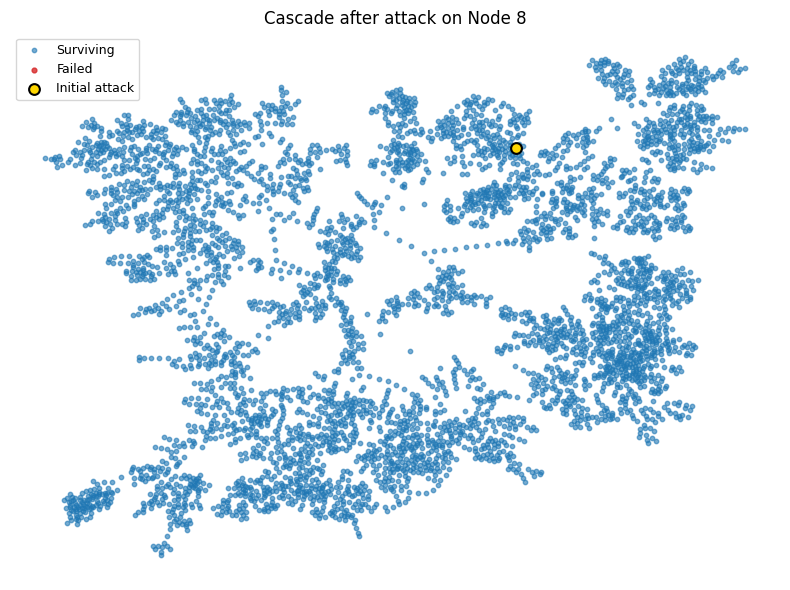

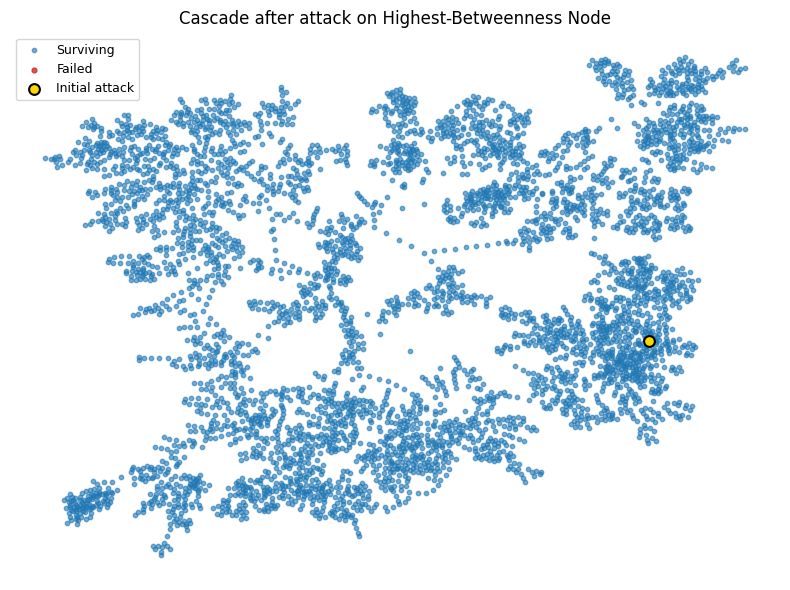

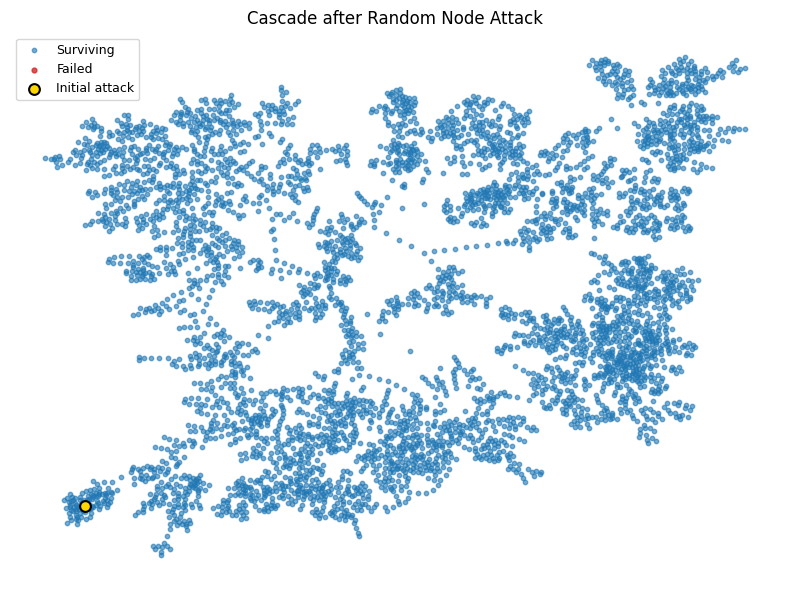

In [7]:
import matplotlib.pyplot as plt

def plot_cascade(G_original, result, title=None, attacked_node=None):
    G_final = result["final_graph"]
    failed = result["failed_nodes"]

    pos = nx.get_node_attributes(G_original, "pos")

    plt.figure(figsize=(8, 6))

    surviving = [n for n in G_final.nodes()]
    nx.draw_networkx_nodes(
        G_original,
        pos,
        nodelist=surviving,
        node_size=10,
        node_color="tab:blue",
        alpha=0.6,
        label="Surviving"
    )

    failed_existing = [n for n in failed if n in pos]
    nx.draw_networkx_nodes(
        G_original,
        pos,
        nodelist=failed_existing,
        node_size=12,
        node_color="tab:red",
        alpha=0.8,
        label="Failed"
    )

    if attacked_node is not None and attacked_node in pos:
        nx.draw_networkx_nodes(
            G_original,
            pos,
            nodelist=[attacked_node],
            node_size=60,
            node_color="gold",
            edgecolors="black",
            linewidths=1.5,
            label="Initial attack"
        )

    plt.title(title or "Cascading Failure Outcome")
    plt.axis("off")
    plt.legend(scatterpoints=1, fontsize=9)
    plt.tight_layout()
    plt.show()

# Node 8 attack
plot_cascade(
    G0,
    result_node8,
    title="Cascade after attack on Node 8",
    attacked_node=8
)

# Highest-betweenness attack
plot_cascade(
    G0,
    result_top,
    title="Cascade after attack on Highest-Betweenness Node",
    attacked_node=top_node
)

# Random node attack
plot_cascade(
    G0,
    result_rand,
    title="Cascade after Random Node Attack",
    attacked_node=rand_node
)

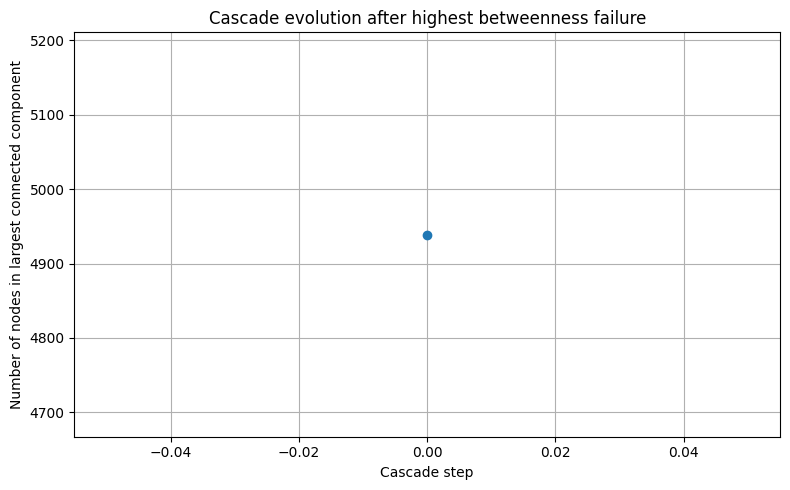

In [8]:
import matplotlib.pyplot as plt
lcc=result_top["lcc_history"]
steps=range(len(lcc))

plt.figure(figsize=(8,5))
plt.plot(steps, lcc, marker='o')
plt.xlabel("Cascade step")
plt.ylabel("Number of nodes in largest connected component")
plt.title("Cascade evolution after highest betweenness failure")
plt.grid(True)
plt.tight_layout()
plt.show()

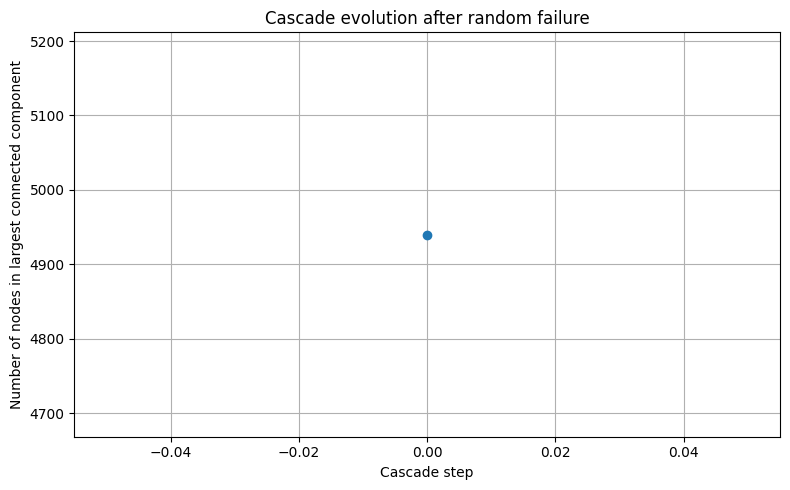

In [9]:
lcc_rand=result_rand["lcc_history"]
steps_rand=range(len(lcc_rand))

plt.figure(figsize=(8,5))
plt.plot(steps_rand, lcc_rand, marker='o')
plt.xlabel("Cascade step")
plt.ylabel("Number of nodes in largest connected component")
plt.title("Cascade evolution after random failure")
plt.grid(True)
plt.tight_layout()
plt.show()

Graph loaded: 4941 nodes, 6594 edges
   attack_size  total_failed  largest_cc  steps
0            1             1        4939      1
1            6            10        4897      4
2           11            18        4866      4
3           16            23        4847      4
4           21            28        4805      4


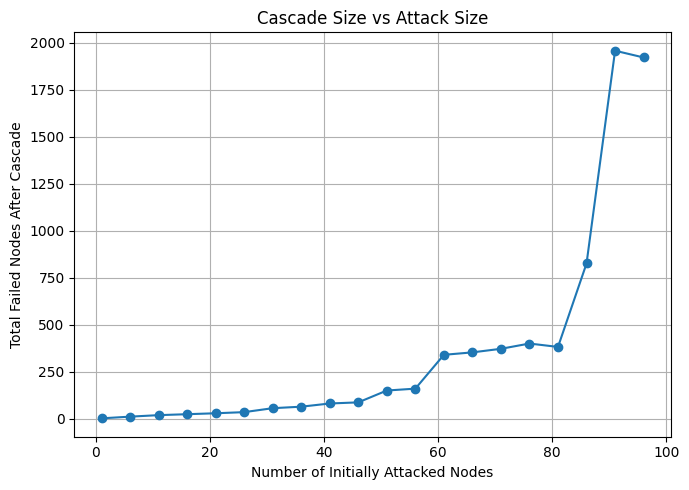

In [10]:
import pandas as pd

def load_data_with_attributes(edges_path="data/edges.csv", nodes_path="data/nodes_lc.csv"):
    edges = pd.read_csv(edges_path)
    nodes = pd.read_csv(nodes_path)

    G = nx.from_pandas_edgelist(
        edges,
        source="source",
        target="target",
        create_using=nx.Graph(),
    )

    for _, row in nodes.iterrows():
        n = row["index"]

        node_attrs = {}

        if {"pos_x", "pos_y"}.issubset(nodes.columns):
            node_attrs["pos"] = [row["pos_x"], row["pos_y"]]

        for col in nodes.columns:
            if col not in ["index", "pos_x", "pos_y"]:
                node_attrs[col] = row[col]

        G.add_node(n, **node_attrs)

    print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    return G

G = load_data_with_attributes()

def reset_node_states(G):
    for n in G.nodes():
        G.nodes[n]["failed"] = False

def high_degree_node_attack(G0, number_of_nodes=1):
    node_degrees = dict(G.degree())
    sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)
    return [sorted_nodes[i][0] for i in range(number_of_nodes)]

def get_intack_neighbours(G, node):
    return [
        neighbor
        for neighbor in G.neighbors(node)
        if not G.nodes[neighbor]["failed"]
    ]

def calculate_outputs(G):
    intact_nodes = [n for n in G.nodes() if not G.nodes[n]["failed"]]
    failed_nodes = [n for n in G.nodes() if G.nodes[n]["failed"]]

    intact_subgraph = G.subgraph(intact_nodes)
    largest_cc = max(nx.connected_components(intact_subgraph), key=len, default=set())

    return {
        "num_failed_nodes": len(failed_nodes),
        "num_intact_nodes": len(intact_nodes),
        "size_largest_cc": len(largest_cc)
    }

def cascade_failure_proportional_load_distribution(G0, failed_nodes0):
    G = G0.copy()

    current_failed = list(failed_nodes0)
    failed_per_step = []
    steps = 0

    while current_failed:
        steps += 1
        new_failed = set()

        for n in current_failed:
            if G.nodes[n]["failed"]:
                continue

            G.nodes[n]["failed"] = True
            neighbors = get_intack_neighbours(G, n)
            load = G.nodes[n]["load"]

            if neighbors:
                total_capacity = sum(G.nodes[v]["capacity"] for v in neighbors)

                for neighbor in neighbors:
                    load_share = (G.nodes[neighbor]["capacity"] / total_capacity) * load
                    G.nodes[neighbor]["load"] += load_share
                    if G.nodes[neighbor]["load"] > G.nodes[neighbor]["capacity"]:
                        new_failed.add(neighbor)

            G.nodes[n]["load"] = 0

        failed_per_step.append(len(new_failed))
        current_failed = list(new_failed)

    outputs = calculate_outputs(G)
    return G, steps, failed_per_step, outputs

def run_attack_experiment(G0, attack_size):
    G = G0.copy()
    reset_node_states(G)

    attacked_nodes = high_degree_node_attack(G, attack_size)

    G_after, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(
        G, attacked_nodes
    )

    return {
        "attack_size": attack_size,
        "total_failed": outputs["num_failed_nodes"],
        "largest_cc": outputs["size_largest_cc"],
        "steps": steps
    }


def draw_graph_after_failure(G, title):
    pos = nx.get_node_attributes(G, "pos")

    plt.figure(figsize=(10, 8))

    failed_edges = []
    intact_edges = []
    for u, v in G.edges():
        if G.nodes[u]["failed"] and G.nodes[v]["failed"]:
            failed_edges.append((u, v))
        else:
            intact_edges.append((u, v))

    nx.draw_networkx_edges(G, pos, edgelist=intact_edges, edge_color='grey', alpha=0.7)

    nx.draw_networkx_edges(G, pos, edgelist=failed_edges, edge_color='red', alpha=0.9)

    node_colors = ["#9c0101" if G.nodes[n]["failed"] else "#50bee6" for n in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3)

    plt.title(title)
    plt.axis('off')
    plt.show()

attacked_nodes = high_degree_node_attack(G, number_of_nodes=50)
G_after_failure, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(G, attacked_nodes)

results = []

attack_sizes = range(1, 101, 5)  # adjust as needed

for k in attack_sizes:
    result = run_attack_experiment(G, k)
    results.append(result)

df_degree = pd.DataFrame(results)
print(df_degree.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(df_degree["attack_size"], df_degree["total_failed"], marker="o")
plt.xlabel("Number of Initially Attacked Nodes")
plt.ylabel("Total Failed Nodes After Cascade")
plt.title("Cascade Size vs Attack Size")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def load_data_with_attributes(edges_path="data/edges.csv", nodes_path="data/nodes_lc.csv"):
    edges = pd.read_csv(edges_path)
    nodes = pd.read_csv(nodes_path)

    G = nx.from_pandas_edgelist(
        edges,
        source="source",
        target="target",
        create_using=nx.Graph(),
    )

    for _, row in nodes.iterrows():
        n = row["index"]

        node_attrs = {}

        if {"pos_x", "pos_y"}.issubset(nodes.columns):
            node_attrs["pos"] = [row["pos_x"], row["pos_y"]]

        for col in nodes.columns:
            if col not in ["index", "pos_x", "pos_y"]:
                node_attrs[col] = row[col]

        G.add_node(n, **node_attrs)

    print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    return G


G = load_data_with_attributes()

def reset_node_states(G):
    for n in G.nodes():
        G.nodes[n]["failed"] = False


betweenness = nx.betweenness_centrality(G, normalized=True)

sorted_nodes = [
    n for n, _ in sorted(
        betweenness.items(),
        key=lambda x: x[1],
        reverse=True
    )
]


def high_betweenness_node_attack(sorted_nodes, number_of_nodes):
    return sorted_nodes[:number_of_nodes]


def get_intack_neighbours(G, node):
    return [
        neighbor
        for neighbor in G.neighbors(node)
        if not G.nodes[neighbor]["failed"]
    ]


def calculate_outputs(G):
    intact_nodes = [n for n in G.nodes() if not G.nodes[n]["failed"]]
    failed_nodes = [n for n in G.nodes() if G.nodes[n]["failed"]]

    intact_subgraph = G.subgraph(intact_nodes)
    largest_cc = max(nx.connected_components(intact_subgraph), key=len, default=set())

    return {
        "num_failed_nodes": len(failed_nodes),
        "num_intact_nodes": len(intact_nodes),
        "size_largest_cc": len(largest_cc)
    }


def cascade_failure_proportional_load_distribution(G0, failed_nodes0):
    G = G0.copy()

    current_failed = list(failed_nodes0)
    failed_per_step = []
    steps = 0

    while current_failed:
        steps += 1
        new_failed = set()

        for n in current_failed:
            if G.nodes[n]["failed"]:
                continue

            G.nodes[n]["failed"] = True
            neighbors = get_intack_neighbours(G, n)
            load = G.nodes[n]["load"]

            if neighbors:
                total_capacity = sum(G.nodes[v]["capacity"] for v in neighbors)

                for neighbor in neighbors:
                    load_share = (G.nodes[neighbor]["capacity"] / total_capacity) * load
                    G.nodes[neighbor]["load"] += load_share
                    if G.nodes[neighbor]["load"] > G.nodes[neighbor]["capacity"]:
                        new_failed.add(neighbor)

            G.nodes[n]["load"] = 0

        failed_per_step.append(len(new_failed))
        current_failed = list(new_failed)

    outputs = calculate_outputs(G)
    return G, steps, failed_per_step, outputs


def run_betweenness_attack_experiment(G0, attack_size, sorted_nodes):
    G = G0.copy()
    reset_node_states(G)

    attacked_nodes = high_betweenness_node_attack(
        sorted_nodes, attack_size
    )

    G_after, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(
        G, attacked_nodes
    )

    return {
        "attack_size": attack_size,
        "total_failed": outputs["num_failed_nodes"],
        "largest_cc": outputs["size_largest_cc"],
        "steps": steps
    }


results_bc = []

attack_sizes = range(1, 101, 5)

for k in attack_sizes:
    result = run_betweenness_attack_experiment(G, k, sorted_nodes)
    results_bc.append(result)

df_bc = pd.DataFrame(results_bc)
print(df_bc)


plt.figure(figsize=(7, 5))
plt.plot(
    df_bc["attack_size"],
    df_bc["total_failed"],
    marker="o",
    label="Betweenness-based attack"
)

plt.xlabel("Number of Initially Attacked Nodes")
plt.ylabel("Total Failed Nodes After Cascade")
plt.title("Cascade Size vs Betweenness-Based Attack Size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Graph loaded: 4941 nodes, 6594 edges


KeyboardInterrupt: 

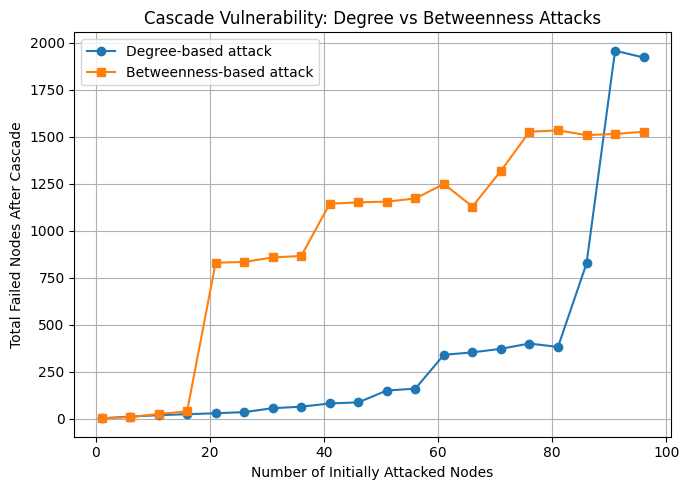

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(
    df_degree["attack_size"],
    df_degree["total_failed"],
    marker="o",
    label="Degree-based attack"
)

plt.plot(
    df_bc["attack_size"],
    df_bc["total_failed"],
    marker="s",
    label="Betweenness-based attack"
)

plt.xlabel("Number of Initially Attacked Nodes")
plt.ylabel("Total Failed Nodes After Cascade")
plt.title("Cascade Vulnerability: Degree vs Betweenness Attacks")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

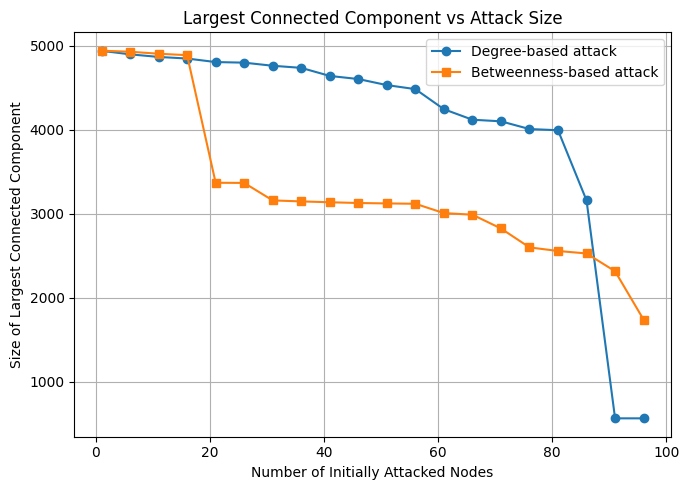

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(
    df_degree["attack_size"],
    df_degree["largest_cc"],
    marker="o",
    label="Degree-based attack"
)

plt.plot(
    df_bc["attack_size"],
    df_bc["largest_cc"],
    marker="s",
    label="Betweenness-based attack"
)

plt.xlabel("Number of Initially Attacked Nodes")
plt.ylabel("Size of Largest Connected Component")
plt.title("Largest Connected Component vs Attack Size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from importlib import reload
from matplotlib import pyplot as plt
import numpy as np
import src.data
import cascade_failure.simple_cascade
import src.visualization
import src.atack
reload(cascade_failure.simple_cascade)
reload(src.data)
reload(src.visualization)
reload(src.atack)

from src.data import load_data_with_attributes
from src.visualization import draw_graph_after_failure, draw_graph_with_node_highlighted, draw_graph_after_failure_with_attacked_nodes
from cascade_failure.simple_cascade import cascade_failure_equal_load_distribution, cascade_failure_proportional_load_distribution
from src.atack import random_node_attack, high_degree_node_attack, high_load_capacity_ratio_node_attack, high_load_capacity_ratio_and_degree_node_attack, high_load_node_attack,high_betweenness_node_attack

In [ ]:
G = load_data_with_attributes()

In [ ]:
def hihi_lcr(G0, num_nodes_to_attack):
    num_failed_nodes = [0, 0, 0, 0]

    # Proportional Load Distribution
    G = G0.copy()
    attacked_nodes = high_betweenness_node_attack(G, number_of_nodes=num_nodes_to_attack)
    G, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(G, attacked_nodes)
    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Proportional Load Distribution")
    print(f"Number of cascade steps: {steps}")
    print(f"Failed nodes per step: {failed_per_step}")
    print(f"Final outputs: {outputs}")
    print("Attacked nodes:", attacked_nodes)
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    num_failed_nodes[0] = num_failed

    # Equal Load Distribution
    G = G0.copy()
    attacked_nodes = high_betweenness_node_attack(G, number_of_nodes=num_nodes_to_attack)
    G, steps, failed_per_step, outputs = cascade_failure_equal_load_distribution(G, attacked_nodes)
    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Equal Load Distribution")
    print(f"Number of cascade steps: {steps}")
    print(f"Failed nodes per step: {failed_per_step}")
    print(f"Final outputs: {outputs}")
    print("Attacked nodes:", attacked_nodes)
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    num_failed_nodes[1] = num_failed

    #Proportional Load Distribution sequential 50 node attacks
    G = G0.copy()
    attacked_nodes = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_betweenness_node_attack(G, number_of_nodes=1, k=50)
        attacked_nodes.extend(attacked_node)
        G, _, _, _ = cascade_failure_proportional_load_distribution(G, attacked_node)

    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Proportional Load Distribution")
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    print(f"Total failed nodes after sequential attacks: {num_failed}")
    print("Attacked nodes:", attacked_nodes)
    num_failed_nodes[2] = num_failed

    G = load_data_with_attributes()

    # Equal Load Distribution sequential 50 node attacks
    G = G0.copy()
    attacked_nodes = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_betweenness_node_attack(G, number_of_nodes=1, k=50)
        attacked_nodes.extend(attacked_node)
        G, _, _, _ = cascade_failure_equal_load_distribution(G, attacked_node)

    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Equal Load Distribution")
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    print(f"Total failed nodes after sequential attacks: {num_failed}")
    print("Attacked nodes:", attacked_nodes)
    num_failed_nodes[3] = num_failed

    return num_failed_nodes


def hihi_l(G0, num_nodes_to_attack):
    num_failed_nodes = [0, 0, 0, 0]

    # Proportional Load Distribution
    G = G0.copy()
    attacked_nodes = high_load_node_attack(G, number_of_nodes=num_nodes_to_attack)
    G, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(G, attacked_nodes)
    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Proportional Load Distribution")
    print(f"Number of cascade steps: {steps}")
    print(f"Failed nodes per step: {failed_per_step}")
    print(f"Final outputs: {outputs}")
    print("Attacked nodes:", attacked_nodes)
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    num_failed_nodes[0] = num_failed

    # Equal Load Distribution
    G = G0.copy()
    attacked_nodes = high_load_node_attack(G, number_of_nodes=num_nodes_to_attack)
    G, steps, failed_per_step, outputs = cascade_failure_equal_load_distribution(G, attacked_nodes)
    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Equal Load Distribution")
    print(f"Number of cascade steps: {steps}")
    print(f"Failed nodes per step: {failed_per_step}")
    print(f"Final outputs: {outputs}")
    print("Attacked nodes:", attacked_nodes)
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    num_failed_nodes[1] = num_failed

    # Proportional Load Distribution sequential 50 node attacks
    G = G0.copy()
    attacked_nodes = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_load_node_attack(G, number_of_nodes=1)
        attacked_nodes.extend(attacked_node)
        G, _, _, _ = cascade_failure_proportional_load_distribution(G, attacked_node)

    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Proportional Load Distribution")
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    print(f"Total failed nodes after sequential attacks: {num_failed}")
    print("Attacked nodes:", attacked_nodes)
    num_failed_nodes[2] = num_failed

    G = load_data_with_attributes()

    # Equal Load Distribution sequential 50 node attacks
    G = G0.copy()
    attacked_nodes = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_load_node_attack(G, number_of_nodes=1)
        attacked_nodes.extend(attacked_node)
        G, _, _, _ = cascade_failure_equal_load_distribution(G, attacked_node)

    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Equal Load Distribution")
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    print(f"Total failed nodes after sequential attacks: {num_failed}")
    print("Attacked nodes:", attacked_nodes)
    num_failed_nodes[3] = num_failed

    return num_failed_nodes

In [ ]:
import inspect
print(high_betweenness_node_attack)
print(inspect.getsource(high_betweenness_node_attack))
print(inspect.signature(high_betweenness_node_attack))

<function high_betweenness_node_attack at 0x000001EEE17D3EC0>
def high_betweenness_node_attack(G, number_of_nodes=1, k=None):
    intact = intact_nodes(G)
    betweenness = nx.betweenness_centrality(G.subgraph(intact), normalized=True, k=k)
    failed_nodes = sorted(
        betweenness,
        key=betweenness.get,
        reverse=True
    )[:number_of_nodes]

    return failed_nodes

(G, number_of_nodes=1, k=None)


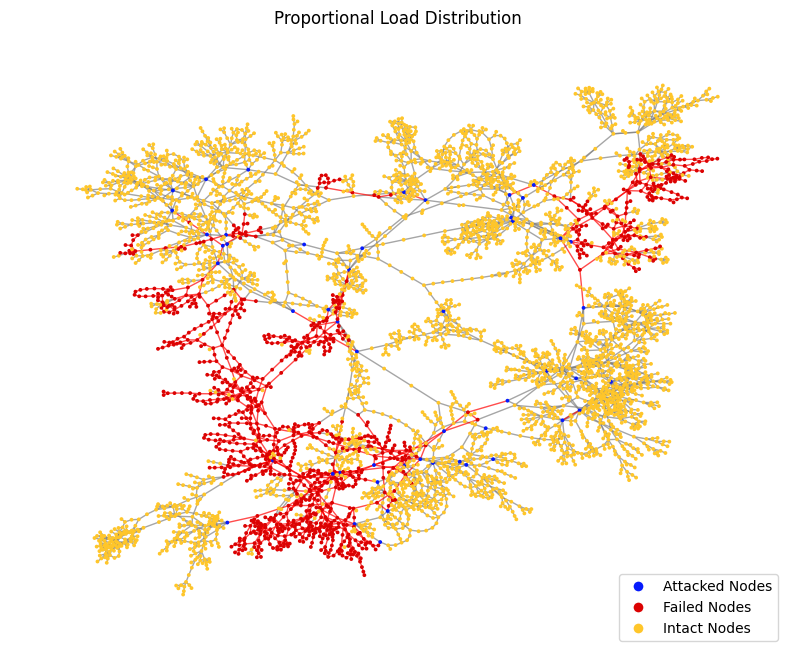

Total failed nodes after sequential attacks: 1142
Attacked nodes: [2543, 426, 2235, 1091, 393, 1244, 69, 2585, 2364, 4652, 4574, 2489, 2231, 2321, 4837, 1030, 1243, 1106, 2594, 1313, 2458, 1163, 1072, 1523, 1219, 1069, 4164, 129, 2562, 4458, 532, 285, 3979, 1140, 4474, 3312, 4876, 1334, 3352, 3329, 4476, 4686, 1757, 207, 521, 1116, 1506, 2554, 2617, 1102]


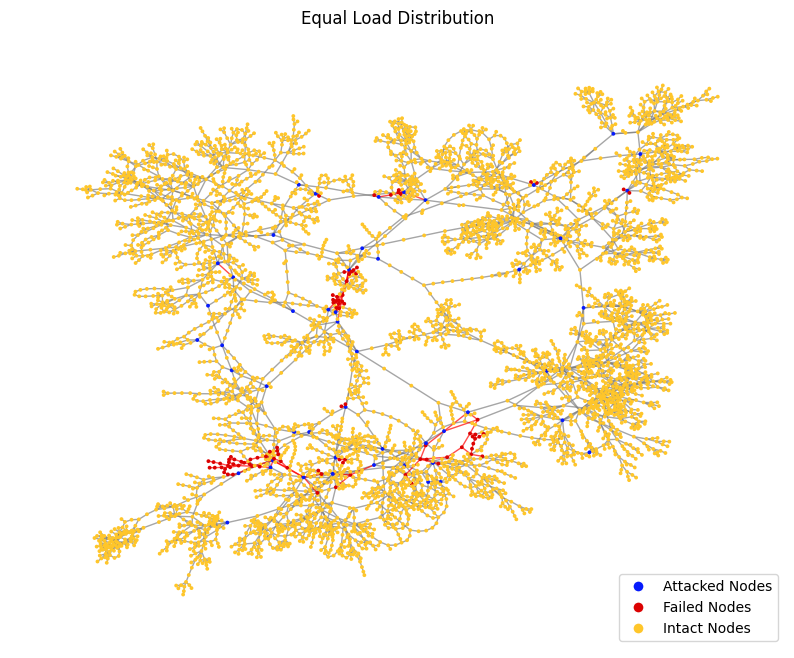

Total failed nodes after sequential attacks: 141
Attacked nodes: [4164, 1308, 1243, 426, 2235, 69, 2543, 1091, 393, 4832, 4652, 1244, 2364, 2231, 1030, 3982, 4848, 1106, 2458, 4878, 4893, 2839, 4106, 750, 744, 2233, 2249, 402, 2321, 2414, 285, 2405, 4588, 1166, 1252, 1119, 1326, 129, 692, 1506, 3781, 1102, 1622, 1090, 1930, 1406, 1204, 2585, 1098, 4199]


In [ ]:
fn_1 = hihi_lcr(G, 50)
#fn_2 = hihi_l(G, 50)

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def load_data_with_attributes(edges_path="data/edges.csv", nodes_path="data/nodes_lc.csv"):
    edges = pd.read_csv(edges_path)
    nodes = pd.read_csv(nodes_path)

    G = nx.from_pandas_edgelist(
        edges,
        source="source",
        target="target",
        create_using=nx.Graph(),
    )

    for _, row in nodes.iterrows():
        n = row["index"]

        node_attrs = {}

        if {"pos_x", "pos_y"}.issubset(nodes.columns):
            node_attrs["pos"] = [row["pos_x"], row["pos_y"]]

        for col in nodes.columns:
            if col not in ["index", "pos_x", "pos_y"]:
                node_attrs[col] = row[col]

        G.add_node(n, **node_attrs)

    print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    return G


G = load_data_with_attributes()

def reset_node_states(G):
    for n in G.nodes():
        G.nodes[n]["failed"] = False


betweenness = nx.betweenness_centrality(G, normalized=True)

sorted_nodes = [
    n for n, _ in sorted(
        betweenness.items(),
        key=lambda x: x[1],
        reverse=True
    )
]


def high_betweenness_node_attack(sorted_nodes, number_of_nodes):
    return sorted_nodes[:number_of_nodes]


def get_intack_neighbours(G, node):
    return [
        neighbor
        for neighbor in G.neighbors(node)
        if not G.nodes[neighbor]["failed"]
    ]


def calculate_outputs(G):
    intact_nodes = [n for n in G.nodes() if not G.nodes[n]["failed"]]
    failed_nodes = [n for n in G.nodes() if G.nodes[n]["failed"]]

    intact_subgraph = G.subgraph(intact_nodes)
    largest_cc = max(nx.connected_components(intact_subgraph), key=len, default=set())

    return {
        "num_failed_nodes": len(failed_nodes),
        "num_intact_nodes": len(intact_nodes),
        "size_largest_cc": len(largest_cc)
    }


def cascade_failure_proportional_load_distribution(G0, failed_nodes0):
    G = G0.copy()

    current_failed = list(failed_nodes0)
    failed_per_step = []
    steps = 0

    while current_failed:
        steps += 1
        new_failed = set()

        for n in current_failed:
            if G.nodes[n]["failed"]:
                continue

            G.nodes[n]["failed"] = True
            neighbors = get_intack_neighbours(G, n)
            load = G.nodes[n]["load"]

            if neighbors:
                total_capacity = sum(G.nodes[v]["capacity"] for v in neighbors)

                for neighbor in neighbors:
                    load_share = (G.nodes[neighbor]["capacity"] / total_capacity) * load
                    G.nodes[neighbor]["load"] += load_share
                    if G.nodes[neighbor]["load"] > G.nodes[neighbor]["capacity"]:
                        new_failed.add(neighbor)

            G.nodes[n]["load"] = 0

        failed_per_step.append(len(new_failed))
        current_failed = list(new_failed)

    outputs = calculate_outputs(G)
    return G, steps, failed_per_step, outputs

Graph loaded: 4941 nodes, 6594 edges


0.28841562147939614


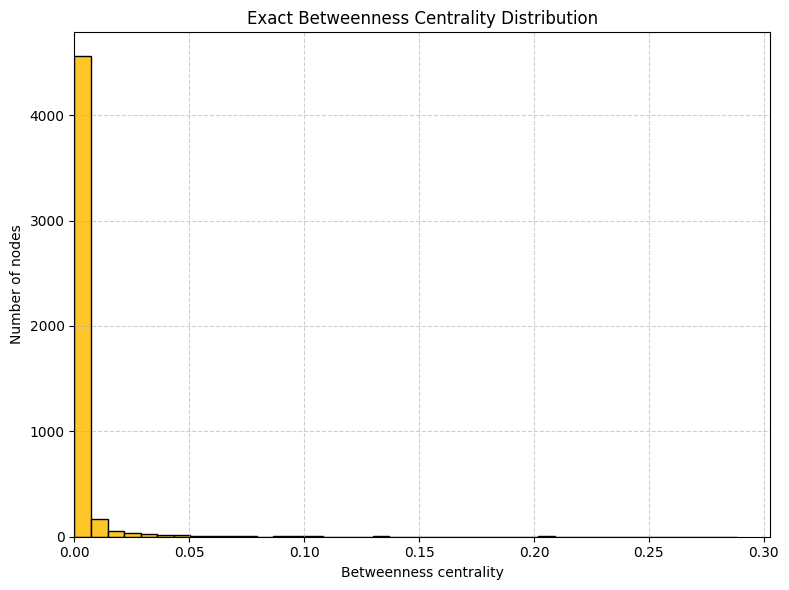

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_betweenness_distribution(G, bins=40):
    betweenness = nx.betweenness_centrality(G, normalized=True)

    values = np.array(list(betweenness.values()))
    print(max(values))

    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=bins, edgecolor="black", color='#ffc62a')
    plt.xlabel("Betweenness centrality")
    plt.ylabel("Number of nodes")
    plt.title("Exact Betweenness Centrality Distribution")
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(left=0)
    plt.show()

plot_betweenness_distribution(G)